# Fresnel Propagation with POPPY 

`poppy` now includes support for Fresnel propagation. This notebook demonstrates some of that functionality.

## Basics: FresnelWavefront and propagation through free space

The API has been kept as similar as possible to the original Fraunhofer mode of `poppy`. There are `FresnelWavefront` and `FresnelOpticalSystem` classes, which can be used for the most part similar to the `Wavefront` and `OpticalSystem` classes. There are a few key differences however. 

First and foremost, the user must specify the physical separation between optics and must explicitly include lenses to refocus beams, rather than simply letting that automatically be handled under the Fraunhofer assumptions. 
A second notable difference is that the `Fresnel` classes make use of the `astropy.Quantities` framework for units conversion, particularly for propagation distances. 

To support Fresnel propagation, under the hood `poppy` makes use of several different propagation algorithms, and `FresnelWavefront`s may be represented on circular as well as planar surfaces. The approach is generally similar to that taken by John Krist's package PROPER (available from http://proper-library.sourceforge.net), for any users who are familiar with that. 

### Example 1: Edge ringing after a circular aperture

Let us begin by demonstrating the propagation of a plane wave through an aperture, and examine the resulting intensity pattern after some distance through free space. 

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import poppy
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits

/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


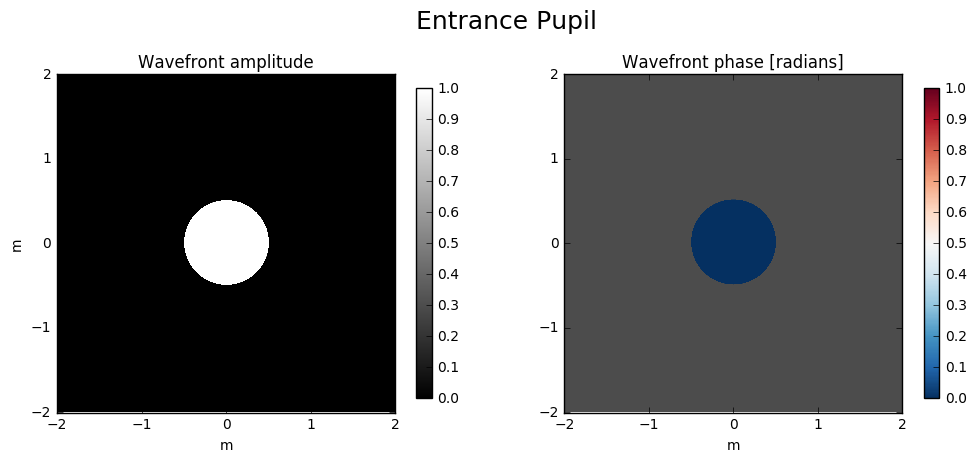

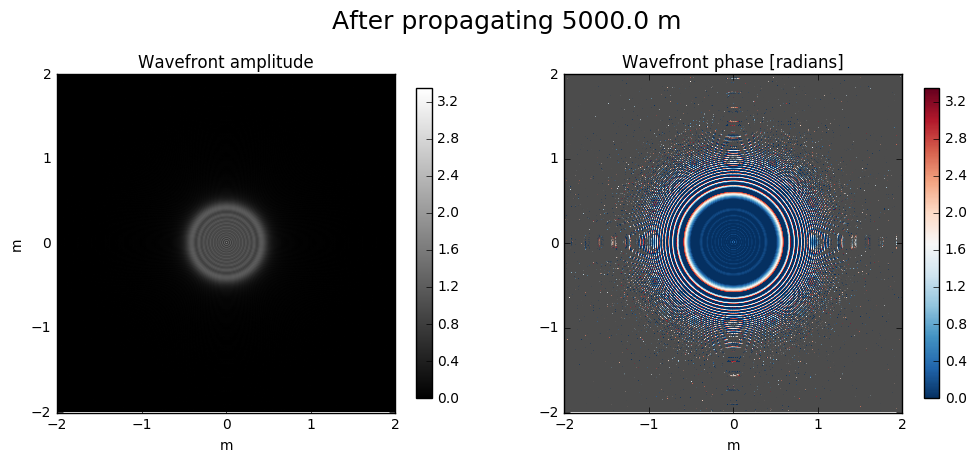

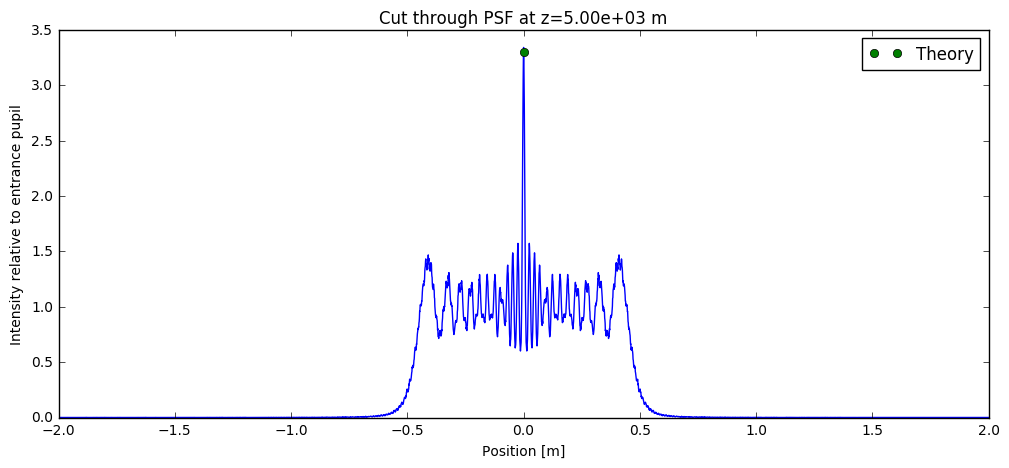

In [14]:
npix = 1024 # ~512 is minimum to accurately recover the central diffraction spike
wf = poppy.FresnelWavefront(0.5*u.m,wavelength=2200e-9,npix=npix,oversample=4)
wf *= poppy.CircularAperture(radius=0.5) 

plt.figure(figsize=(12,5))
wf.display('both',colorbar=True, showpadding=True)
plt.suptitle("Entrance Pupil", fontsize=18)

z = 5e3*u.m
wf.propagate_fresnel(z)

plt.figure(figsize=(12,5))
wf.display('both',colorbar=True)
plt.suptitle("After propagating {}".format(z), fontsize=18)

plt.figure(figsize=(12,5))
y, x = wf.coordinates()
plt.plot(x[wf.intensity.shape[1]/2,:], wf.intensity[wf.intensity.shape[1]/2,:])
plt.title("Cut through PSF at z={:0.2e}".format(z))
plt.xlabel('Position [m]')
plt.ylabel('Intensity relative to entrance pupil')

plt.plot([0], [3.30], 'o', label='Theory')
plt.legend(loc='upper right')

We see the expected ringing from the aperture edges. The peak intensity agrees well with the expected theoretical value. Note that, as with any numerical calculation, the degree of accuracy achieved depends on the details of the wavefront sampling and so forth. Here we chose to perform this calculation at moderately high resolution (1024 pixels across the illuminated pupil, times a sampling factor of 4, therefore 4096x4096 arrays are used to represent the wavefront.)


#### Some differences from Fraunhofer propagation, part 1:

The Fresnel propagation API necessarily differs in several ways from the original Fraunhofer API in `poppy`. Let's highlight a few of the key differences. 

First, when we define a Fresnel wavefront, the first argument specifies the desired diameter of the wavefront, and is given as an `astropy.Quantity` of dimension length: 

In [15]:
import astropy.units as u
wf_fresnel = poppy.FresnelWavefront(0.5*u.m,wavelength=2200e-9,npix=npix,oversample=4)
# versus:
wf_fraunhofer = poppy.Wavefront(diam=0.5, wavelength=2200e-9,npix=npix,oversample=4)

The Fresnel code relies on the `Quantity` framework to enforce consistent units and dimensionality. You can use any desired unit of length, from nanometers to parsecs and beyond, and the code will convert units appropriately. 

This also shows up when requesting an optical propagation. Rather than having implicit transformations between pupil and image planes, for Fresnel propagation a specific distance must be given.  This too is a `Quantity` giving a length.

In [16]:
wf.propagate_fresnel(5*u.km)

### Example 2: Divergence of a Gaussian Beam near the Beam Waist

Beams with Gaussian intensity patterns are often encountered, for instance in laser physics or as a close approximation to the exit pupil of a single-mode optical fiber. Gaussian beams have particularly simple propagation, which can be described at all points in space based on a few parameters of the so-called beam waist, for instance the wavelength $\lambda$ and the radius $w_0$ and position $z$ of the waist. 

The Fresnel propagation code makes extensive use internally of Gaussian beam parameters for representing the convergence of spherical waves. Here we demonstrate that the `FresnelWavefront` code can reproduce the well-known variation in beam radius of curvature $R_c$ and beam width $w$ as a function of the propagation distance $z$. These are normalized to the Rayleigh distance $z_R$.

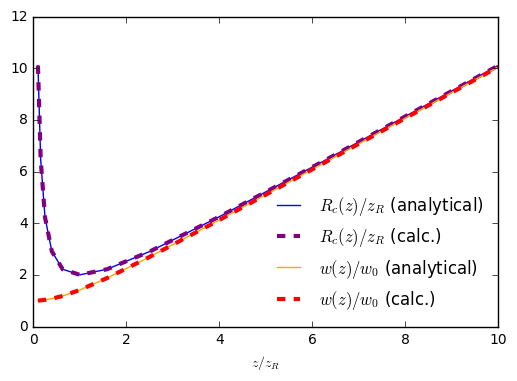

In [17]:
# setup an initial Gaussian beam in an aperture. 

ap = poppy.CircularAperture(radius=1)
wf0 = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=1e-6)

z_rayleigh = wf0.z_r    # the Rayleigh distance

z = z_rayleigh * np.logspace(-1,1,num=11)

calc_rz = []
calc_wz = []
for zi in z:
    #setup entrance wave
    wf = poppy.FresnelWavefront(1*u.m, wavelength=1e-6)
    wf.propagate_fresnel(zi)
    
    # calculate the beam radius and curvature vs z
    calc_rz.append( (wf.r_c()/z_rayleigh).value)
    calc_wz.append( (wf.spot_radius()/wf.w_0).value)
        
# Compare to the analytic solution for Gaussian beam propagation
zdzr = z/z_rayleigh
rz = (z**2 + z_rayleigh**2)/z
wz = wf0.w_0*np.sqrt(1+zdzr**2)

plt.plot(zdzr, rz/z_rayleigh, label="$R_c(z)/z_R$ (analytical)", color='blue')
plt.plot(zdzr, calc_rz, ls='dashed', linewidth=3, color='purple', label="$R_c(z)/z_R$ (calc.)")
plt.plot(zdzr, wz/wf.w_0, label="$w(z)/w_0$ (analytical)", color='orange')
plt.plot(zdzr, calc_wz, ls='dashed', linewidth=3, color='red', label="$w(z)/w_0$ (calc.)")
plt.xlabel("$z/z_R$")
plt.legend(loc='lower right', frameon=False);


The results are as expected.

## Adding Lenses

The parameters of a Gaussian beam may be modified (making it converging or diverging) by adding optical power. In `poppy` this is represented with the `QuadraticLens` class. This is so named because it applies a purely quadratic phase term, i.e. representative of a parabolic mirror or a lens considered in the paraxial approximation. 

Right now, only the Fresnel `QuadraticLens` class will actually cause the Gaussian beam parameters to change. You won't get that effect by adding wavefront error with some other `OpticalElement` class. 

Here we demonstrate a simple telephoto system, applying first a converging lens, then a diverging lens. The beam waist changes after each lens. If we propagate to the resulting final beam waist (i.e. the focus of the combined system), we find the expected Airy pattern at a finite distance from the entrance pupil. 

After aperture, beam waist is at 0.0 m
After lens with focal length 1.0 m, beam waist is at 1.00 m
After propagating 0.50 m, the waist is still at 1.00 m
After lens with focal length -1.0 m, beam waist is at 1.50 m
Propagating 1.00 m to the final focus


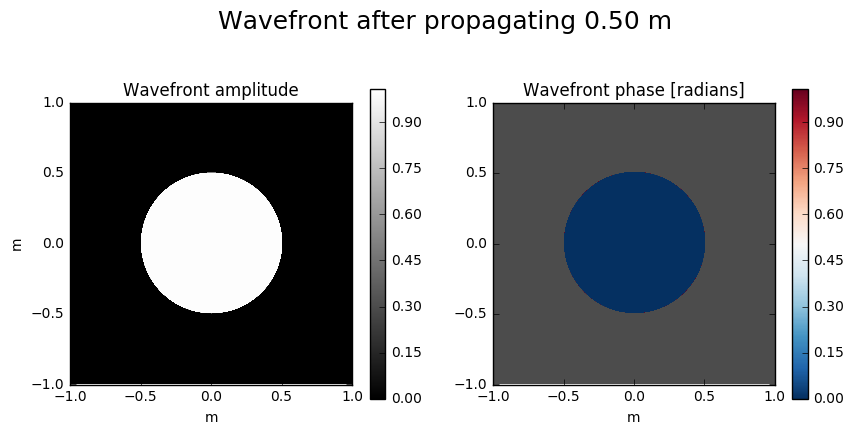

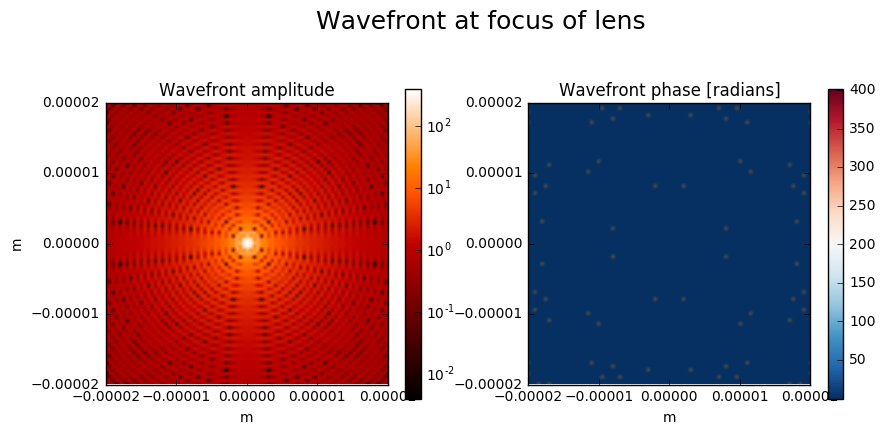

In [18]:
ap = poppy.CircularAperture(radius=1)
wf = poppy.FresnelWavefront(beam_radius=1*u.m, wavelength=1e-6)
wf *= ap
print("After aperture, beam waist is at {}".format(wf.z_w0) )

conv_lens = poppy.QuadraticLens(1.0*u.m)
wf *= conv_lens
print("After lens with focal length {}, beam waist is at {:.2f}".format(conv_lens.fl, wf.z_w0) )

wf.propagate_fresnel(0.5*u.m)
print("After propagating 0.50 m, the waist is still at {:.2f}".format(wf.z_w0))

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront after propagating 0.50 m", fontsize=18)

div_lens = poppy.QuadraticLens(-1*u.m)
wf *= div_lens
print("After lens with focal length {}, beam waist is at {:.2f}".format(div_lens.fl, wf.z_w0) )

print("Propagating {:.2f} to the final focus".format(wf.z_w0 - 0.5*u.m))
wf.propagate_fresnel(wf.z_w0 - 0.5*u.m)


plt.figure(figsize=(10,5))
wf.display('both', colorbar=True, imagecrop=4e-5, scale='log', 
           vmax=wf.amplitude.max(), vmin=wf.amplitude.max()*1e-5)
plt.suptitle("Wavefront at focus of lens", fontsize=18);

## FresnelOpticalSystem

Just like the `OpticalSystem` serves as a high-level container for `OpticalElement`s in Fraunhofer propagation, the `FresnelOpticalSystem` serves the same purpose in Fresnel propagation. 

Note that when adding `OpticalElement`s to the `FresnelOpticalSystem`, you use an `add_optic` function and must specify a physical distance separating that optic from the previous optic. This replaces the `addImage` and `addPupil` methods used in Fraunhofer propagation.

The following example presents a simplified version of the Hubble Space Telescope.

The specific numeric values used for Hubble are taken from the HST example code in the PROPER manual by John Krist,
version 2.0a available from http://proper-library.sourceforge.net
This is not intended as a high-fidelity model of Hubble, and for instance this simplified the primary aperture obscuration, and neglects the specific conic constants of the optics including the infamous spherical aberration.


In [19]:
# HST example - Following example in PROPER Manual V2.0 page 49.
diam = 2.4 * u.m
fl_pri = 5.52085 * u.m
d_pri_sec = 4.907028205 * u.m
fl_sec = -0.6790325 * u.m
d_sec_to_focus = 6.3919974 * u.m

hst = poppy.FresnelOpticalSystem(pupil_diameter=2.4*u.m, npix=512, beam_ratio=0.25)
m1 = poppy.QuadraticLens(fl_pri, name='Primary')
m2 = poppy.QuadraticLens(fl_sec, name='Secondary')

hst.add_optic(poppy.CircularAperture(radius=diam.value/2))
hst.add_optic(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst.add_optic(m1)
hst.add_optic(m2, distance=d_pri_sec)
hst.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'), distance=d_sec_to_focus);

In [20]:
hst.describe()

	Entrance pupil diam:  2.4 m	npix: 512	Beam ratio:0.25
	Optic: Circle, radius=1.2 m
	Pupil plane: Secondary Obscuration with 4 supports (Analytic)
	Lens: Primary, with focal length 5.52085 m
	Propagation distance:  4.907028205 m
	Lens: Secondary, with focal length -0.6790325 m
	Propagation distance:  6.3919974 m
	Image plane: focus (Analytic)


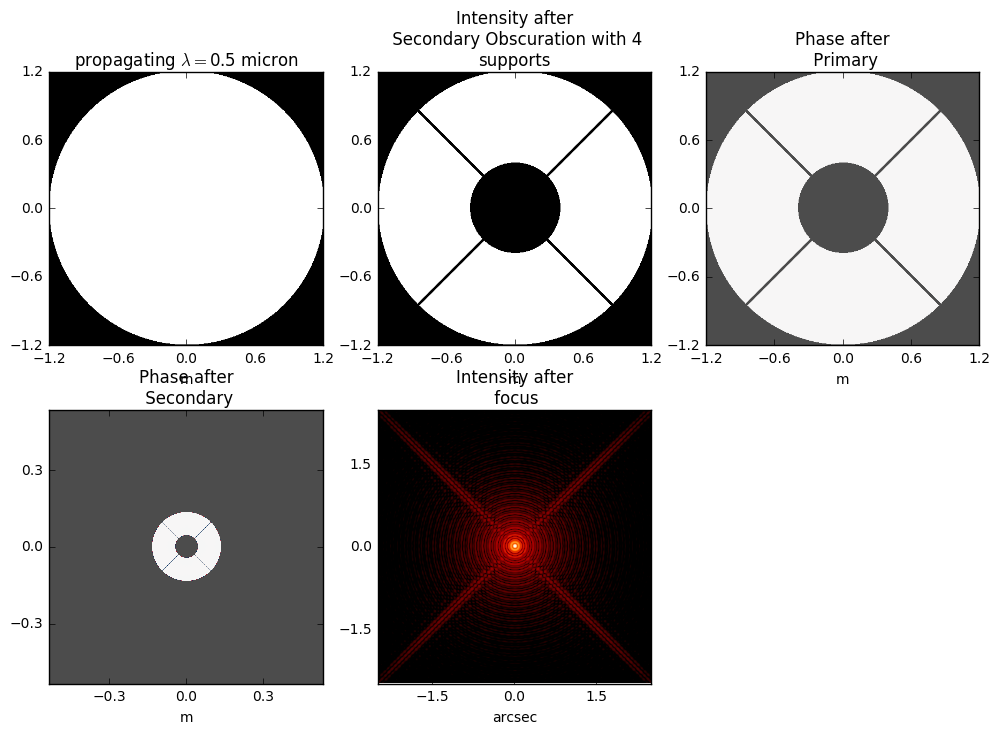

In [21]:
plt.figure(figsize=(12,8))
psf, waves = hst.calcPSF(wavelength=0.5e-6, display_intermediates=True, return_intermediates=True)

The output files are format-compatible with other files produced by `poppy`, and can be used interchangably in the various display and measurement routines.

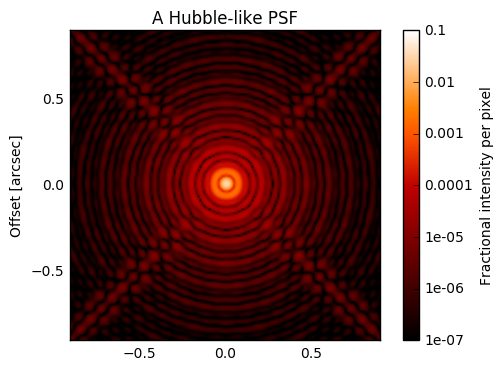

In [22]:
poppy.display_PSF(psf,imagecrop=1.8)
plt.title('A Hubble-like PSF')
plt.ylabel("Offset [arcsec]");


As a check, let's make sure that the PSF is close to what what we would expect for a diffraction limited telescope via the Rayleigh Criterion and Fraunhofer diffraction theory.


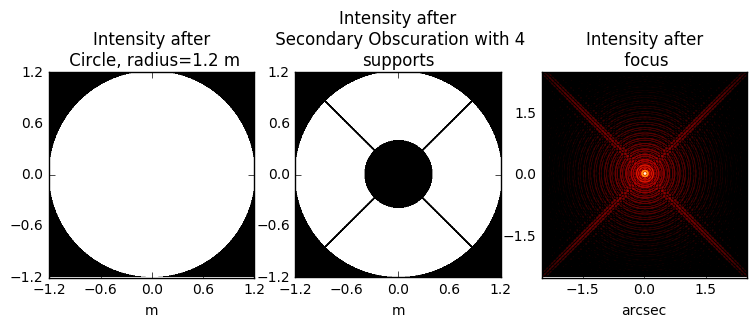

In [23]:
#calculate the Fraunhofer  diffraction pattern of the same aperture
hst_fraunhofer = poppy.OpticalSystem(pupil_diameter=2.4*u.m, npix=512,oversample=4)
hst_fraunhofer.addPupil(poppy.CircularAperture(radius=diam.value/2))
hst_fraunhofer.addPupil(poppy.SecondaryObscuration(secondary_radius=0.396,
                                 support_width=0.0264,
                                 support_angle_offset=45.0))
hst_fraunhofer.addImage(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'));

plt.figure(figsize=[9,3])
fraunhofer_psf = hst_fraunhofer.calcPSF(wavelength=0.5e-6, display_intermediates=True, return_intermediates=False)

/Users/edouglas/anaconda3/envs/poppy-dev/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


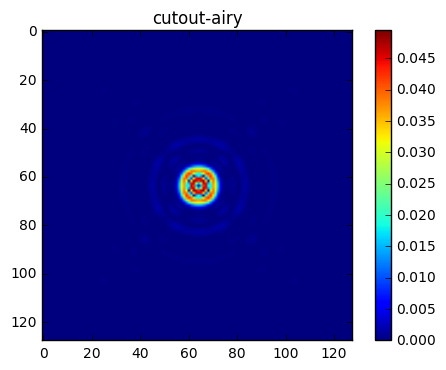

In [25]:
airy=poppy.misc.airy_2d(diameter=diam.value, wavelength=0.5e-6,
                              shape=(128,128), pixelscale=psf[0].header['PIXELSCL'],
                             center=(64,64))
airy_fits=fits.HDUList([fits.PrimaryHDU(airy)])
airy_fits[0].header['PIXELSCL'] = psf[0].header['PIXELSCL']
airy_profile=poppy.utils.radial_profile(airy_fits)


centerpix = hst.npix / hst.beam_ratio / 2
cutout = psf[0].data[centerpix-64:centerpix+64, centerpix-64:centerpix+64] / psf[0].data[centerpix,centerpix]
#plt.subplot(121)
plt.imshow(np.abs(cutout-airy) )
plt.colorbar()
plt.title("cutout-airy")

#assert( np.abs(cutout-airy).max() < 1e-4 )

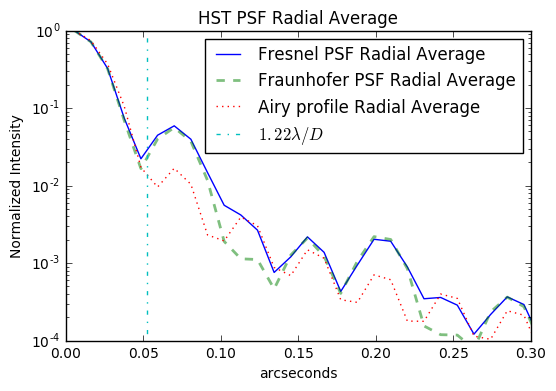

In [26]:
#calculate Airy Pattern
airy=poppy.misc.airy_2d(diameter=diam.value, wavelength=0.5e-6,
                              shape=(128,128), pixelscale=psf[0].header['PIXELSCL'],
                             center=(64,64))
#calculate radial profiles
rayleigh_criterion=1.22*500*u.nm/diam*206265
hst_profile=poppy.utils.radial_profile(psf)
fraunhofer_profile=poppy.utils.radial_profile(fraunhofer_psf)

#plot radial averages:
plt.figure()
plt.plot(hst_profile[0],hst_profile[1]/hst_profile[1].max(),"-",label="Fresnel PSF Radial Average")
plt.plot(fraunhofer_profile[0],fraunhofer_profile[1]/fraunhofer_profile[1].max(),"--",
         linewidth=2,alpha=0.5,label="Fraunhofer PSF Radial Average")
plt.plot(airy_profile[0],airy_profile[1]/airy_profile[1].max(),":",label="Airy profile Radial Average")


plt.yscale("log")
plt.plot([rayleigh_criterion,rayleigh_criterion],[0e-4,1],'-.',label="$1.22\lambda/D$")
plt.xlim([0,0.3])
plt.ylim([1e-4,1])
plt.ylabel("Normalized Intensity")
plt.xlabel("arcseconds")
plt.title("HST PSF Radial Average")
plt.legend()

### A caution on coordinates:


One subtle point to be aware of is a small but important difference in image centering. The Fraunhofer code is set up to by default always place the PSF center precisely in the middle of the array, so for instance in a 1024x1024 array the PSF has its (0,0) origin centered on the crosshairs between pixels [512,512] and [513,513]. In contrast the output of the Fresnel code has the origin (0,0) centered on an integer pixel, which would be [512,512] in this example. This behavior results from the coordinate conventions of the FFT used in the Fresnel propagation. The Fraunhofer code uses a more flexible MFT and if necessary can be adjusted to have its output align with what the Fresnel code does. 

#### Wait, how did it just automatically convert into angular units?

The PSF above is shown in angular units of arcseconds, just like PSFs from `OpticalSystem`. But the Fresnel propagation works in units of meters. In order to convert automatically between the two coordinate systems, Fresnel propagation tracks the focal length of the beam as it encounters powered optics. 

In [27]:
for w in waves:
    print("Focal length {} is {}".format(w.location, w.focal_length))

Focal length after Circle, radius=1.2 m is inf m
Focal length after Secondary Obscuration with 4 supports is inf m
Focal length after Primary is 5.52085 m
Focal length after Secondary is 57.48805474013198 m
Focal length after focus is 57.48805474013198 m


We can cross-check against the combined system focal length using the focal length of each mirror and their separation:

$$\frac{1}{f_{sys}} = \frac{1}{f_1} + \frac{1}{f_2} - \frac{d}{f_1  f_2}$$

In [28]:
print( "fl_sys = {}".format(1./(1./fl_pri + 1./fl_sec - d_pri_sec/(fl_pri*fl_sec))))

fl_sys = 57.48805472391501 m


The answer above is slightly smaller than the generally reported value of 57.6 m for Hubble's focal length.  Numerical experimentation shows that a very small adjustment to the separation to the two optics will resolve this discrepancy. Reducing the assumed primary-to-secondary distance by 0.0025% is sufficient, about 100 microns difference in position out of a nearly 5 meter separation.  But as we noted above, this example case is a simplified version of Hubble and simplifies the actual curvature of the mirrors. This is an acceptably good agreement within those limitations. 

Whenever an image plane optic is encountered in the propagation (i.e. any `OpticalElement` with its `.planetype` equal to `poppy.PlaneType.image`) then the `FresnelWavefront` will automatically return its coordinates in angular units, as expected by that optic. 

If desired you can toggle back and forth manually by setting the `angular_coordinates` attribute, or by setting the `use_angular_coordinates` parameter in the call to `display()`.

Here we show displaying the same PSF in physical units; the PSF peak is only some tens of microns across. 

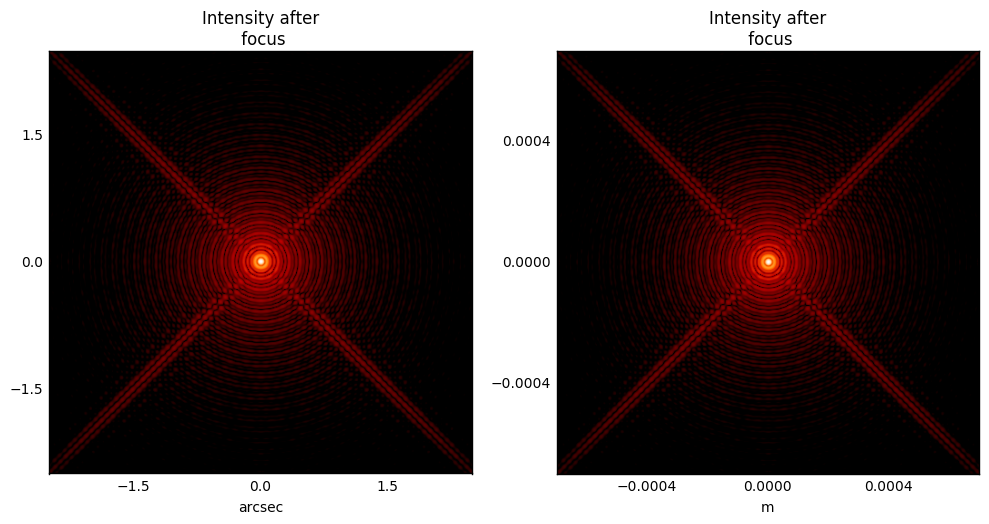

In [29]:
fig, axes=plt.subplots(ncols=2, figsize=(12,6))
waves[-1].display(ax=axes[0], use_angular_coordinates=True)

waves[-1].display(ax=axes[1], use_angular_coordinates=False, 
                  imagecrop= 0.0014) # 1.4 mm happens to yield same FOV as 5 arcsec image default crop
